# Extract features from AudioSet for training

## Load and filter classes
The first thing we need to do is to select the sounds we're going to identify from the labels indexes csv file

In [1]:
import pandas as pd
import pickle

classes_file = "../dataset/class_labels_indices.csv"
selected_classes = ["Vehicle horn, car horn, honking", "Children playing", "Dog", "Jackhammer", "Siren", 
                    "Traffic noise, roadway noise", "Subway, metro, underground", "Walk, footsteps", "Chatter", "Bird"]
df = pd.read_csv(classes_file)
df.set_index("index", inplace=True)
selected_classes_indexes = df.index[df['display_name'].isin(selected_classes)].tolist()

# Create dictionary with our classes
selected_classes_dict = {}
for i in selected_classes_indexes:
    selected_classes_dict[i] = df.iloc[i]['display_name']

print(selected_classes_dict)
# Save for later use
base_dir = "./features/"
dump_filename = f"{base_dir}classes_dict.pkl"

with open(dump_filename, "wb") as dump_file:
    pickle.dump(selected_classes_dict, dump_file)

{53: 'Walk, footsteps', 68: 'Chatter', 71: 'Children playing', 74: 'Dog', 111: 'Bird', 308: 'Vehicle horn, car horn, honking', 327: 'Traffic noise, roadway noise', 334: 'Subway, metro, underground', 396: 'Siren', 420: 'Jackhammer'}


### Create an encoder for our labels

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([selected_classes_indexes])
print(list(mlb.classes_))

# Save mlb for our project
base_dir = "./features/"

dump_filename = f"{base_dir}multiLabelBinarizer.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(mlb, dump_file)

[53, 68, 71, 74, 111, 308, 327, 334, 396, 420]


## Extract features from dataset
Now, we need to build a function to extract features from Google Audioset, which are formatted in tensorflow

In [3]:
import os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def extract_features(dataset_dir, mlb):
    X = []
    y = []
    recordset = os.listdir(dataset_dir)
    for record in recordset:
        raw_dataset = tf.data.TFRecordDataset(dataset_dir+record)    
        for raw_record in raw_dataset.take(-1):
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            labels = example.features.feature['labels'].int64_list.value
            # print(labels)

            for label in labels:
                if label in selected_classes_indexes:
                    # video = example.features.feature['video_id'].bytes_list.value[0].decode("utf-8")
                    # start = example.features.feature['start_time_seconds'].float_list.value[0]
                    # end = example.features.feature['end_time_seconds'].float_list.value[0]
                    # print(f"Video: {video}")
                    # print(f"Duration: {end-start} seconds")
                    
                    labels_detected = set(labels).intersection(set(selected_classes_indexes))
                    # print(f"Labels: ", labels_detected)
                    
                    example_seq = tf.train.SequenceExample()
                    example_seq.ParseFromString(raw_record.numpy())
                    
                    try:
                        i=0
                        feats_list = example_seq.feature_lists.feature_list['audio_embedding']
                        while True:
                            hex_features = feats_list.feature[i].bytes_list.value[0].hex()
                            features_array = [int(hex_features[k:k+2],16) for k in range(0,len(hex_features),2)]
                            # for l in labels_detected:
                                # If there's more than one of the selected labels in the video
                            X.append(features_array)
                            y.append(list(labels_detected))
                            i += 1
                    except IndexError as ie:
                            #FeatureList does not have length, so we read until the end
                            continue
                            
    X = np.array(X)
    y = np.array(y, dtype=object)
    
    # Apply OneHotEncodig to ground truth
    y = mlb.transform(y)

    # We need to add at least one dimension to our X   
    # X = X.reshape(X.shape[0], 128, 1)
    return X,y

### Extract training data

In [4]:
# Extract data for training
X_train, y_train = extract_features("../dataset/audioset_v1_embeddings/bal_train/", mlb)

print(X_train.shape, y_train.shape)

(10697, 128) (10697, 10)


#### Check balance

<AxesSubplot:xlabel='0'>

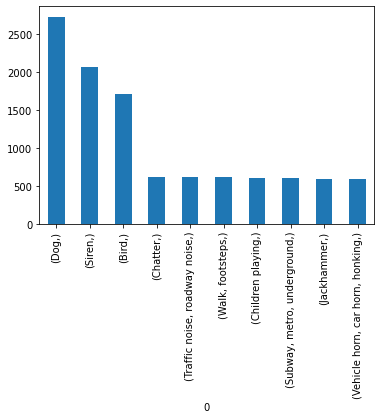

In [5]:
sounds = [selected_classes_dict.get(mlb.classes_[y.argmax()]) for y in y_train]
df = pd.DataFrame(sounds)
df.value_counts().plot.bar()

### Extract evaluation data

In [6]:
# Extract also X and y for validation
X_val, y_val = extract_features("../dataset/audioset_v1_embeddings/eval/", mlb)
print(X_val.shape, y_val.shape)

(10747, 128) (10747, 10)


#### Check balance

<AxesSubplot:xlabel='0'>

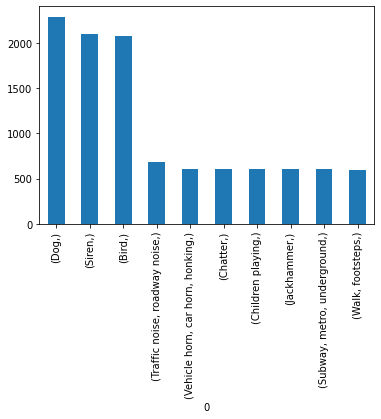

In [7]:
sounds = [selected_classes_dict.get(mlb.classes_[y.argmax()]) for y in y_val]
df = pd.DataFrame(sounds)
df.value_counts().plot.bar()

### Save results for later

In [8]:
from pathlib import Path

# Save training and evaluation sets
Path(base_dir).mkdir(exist_ok=True)   

dump_filename = f"{base_dir}X_train.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(X_train, dump_file)
    
dump_filename = f"{base_dir}y_train.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(y_train, dump_file)
    
dump_filename = f"{base_dir}X_val.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(X_val, dump_file)
    
dump_filename = f"{base_dir}y_val.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(y_val, dump_file)